# Dynamic damages

In [41]:
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from supportfunctions import finiteDiff
import matplotlib.pyplot as plt
from numba import njit

In [2]:
solu = pickle.load(open('../data/solution/solu_dynamicdmg_21*201_0301_16:41', 'rb'))

In [3]:
solu

{'FC_Err': 1,
 'PIThis': array([[[0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,
          0.00338542, 0.00338542],
         [0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,
          0.00338542, 0.00338542],
         [0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,
          0.00338542, 0.00338542],
         ...,
         [0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,
          0.00338542, 0.00338542],
         [0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,
          0.00338542, 0.00338542],
         [0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,
          0.00338542, 0.00338542]],
 
        [[0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,
          0.00338542, 0.00338542],
         [0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,
          0.00338542, 0.00338542],
         [0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,
          0.00338542, 0.00338542],
         ...,
         [0.00338542, 0.00338542, 0.00338542, ..., 0.00338542,


In [3]:
solu['y_grid'][100]

2.0

In [4]:
solu['sigma2']

0.002177598558933893

In [5]:
# backward induction
rho = .9
mu2 = 1.86/1000
sigma2 = 0.002177598558933893
error = 1
tol = 1e-8
episode = 0
epsilon = .3

In [6]:
solu_dict = solu['solu_dynamicdmg']
z_grid = solu['z_grid']
y_grid = solu['y_grid']
hz = solu['hz']
hy = solu['hy']
delta = .01
eta = .032
v_n = solu['v_n']

In [7]:
y_grid_new = y_grid[:101]
gamma2pList = np.array([2*0.0197, 2*0.3853])
v0 = solu_dict[0]['phi'][:, :101]
v1 = solu_dict[gamma2pList[0]]['phi'][:, :101]
v2 = solu_dict[gamma2pList[1]]['phi'][:, :101]
# numy = len(y_new)
numz = len(z_grid)
numy = len(y_grid_new)
numy

101

In [8]:
numdmg = 3
tran_prob = np.ones((numdmg-1, numz, numy))/(numdmg-1)

In [9]:
v1.shape,tran_prob.shape

((21, 101), (2, 21, 101))

In [10]:
(z_mat, y_mat) = np.meshgrid(z_grid, y_grid_new, indexing='ij')
stateSpace = np.hstack([z_mat.reshape(-1,1,order='F'), y_mat.reshape(-1,1,order='F')])

In [11]:
gamma2pMat = np.zeros((numdmg-1, numz, numy))
gamma2pMat[0] = gamma2pList[0]
gamma2pMat[1] = gamma2pList[1]
dlambdaMat = dLambda(y_mat, 1, 0.00017675, 2*0.0022, np.sum(gamma2pMat*tran_prob, axis=0), 2)

In [12]:
dlambdaMat.shape

(21, 101)

In [13]:
target = np.array([v1,v2])
target.shape, dlambdaMat.shape

((2, 21, 101), (21, 101))

In [14]:
V = np.sum(tran_prob*target, axis=0)
terminal_v = v0[:,-1]

In [15]:
V = np.sum(tran_prob*target, axis=0)
terminal_v = v0[:,-1]

In [99]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
@njit
def pde_solver(phi_grid, z_grid, y_grid, terminal_condition, dlambdaMat, epsilon=.3,
           delta=.01, eta=.032, 
           mu2=1.86/1000, sigma2=0.002177598558933893, rho=.9):
    
    n_y = len(y_grid)
    n_z = len(z_grid)
    hy = y_grid[1] - y_grid[0]
    hz = z_grid[1] - z_grid[0]
    LHS = np.zeros((n_y*n_z, n_y*n_z))
    RHS = np.zeros(n_y*n_z)
    for j in range(n_z):
        for i in range(n_y):
            idx = j*n_y + i
            idx_yp1 = idx + 1
            idx_ym1 = idx - 1
            idx_zp1 = (j+1)*n_y + i
            idx_zp2 = (j+2)*n_y + i
            idx_zm1 = (j-1)*n_y + i
            idx_zm2 = (j-2)*n_y + i
            phi = phi_grid[idx]
            z = z_grid[j]
            condition = terminal_condition[j]
            dlambda = dlambdaMat[j,i]
            LHS[idx, idx] += - delta - 1/epsilon
            temp_1 = -rho*(z-mu2)
            var = z*sigma2**2/2
            # assign coefficient
            if j == 0:
                LHS[idx, idx] += -temp_1/hz + var/(hz**2)  
                LHS[idx, idx_zp1] += temp_1/hz - var*2/(hz**2)
                LHS[idx, idx_zp2] += var/(hz**2)
            elif j == n_z-1:
                LHS[idx, idx] += temp_1/hz + var/(hz**2)
                LHS[idx, idx_zm1] += -temp_1/hz - var*2/(hz**2)
                LHS[idx, idx_zm2] += var/(hz**2)            
            else:
                LHS[idx, idx] += temp_1*((-1./hz) * (temp_1 > 0) + (1./hz) * (temp_1<=0))- var*2/(hz**2)
                LHS[idx, idx_zp1] += temp_1 * (1/hz) * (temp_1 > 0) + var/(hz**2)
                LHS[idx, idx_zm1] +=  temp_1 * (-1./hz) * (temp_1<=0)+ var/(hz**2)
            
            if i == 0:
                dphidy= (phi_grid[idx_yp1]-phi_grid[idx])/hy
                e = - delta*eta/(dphidy*z + (eta-1)*dlambda*z)
                LHS[idx, idx] +=  - z*e/hy
                LHS[idx, idx_yp1] += z*e/hy
                RHS[idx] = -1/epsilon*phi - delta*eta*np.log(e) - (eta-1)*dlambda*z*e
            elif i >= 1 and i< n_y-1:
                dphidy = (phi_grid[idx_yp1]-phi_grid[idx_ym1])/(2*hy)
                e = - delta*eta/(dphidy*z + (eta-1)*dlambda*z)
                LHS[idx, idx] = z*e * ((-1./hy) * (z*e>0) + (1./hy) * (z*e<=0))
                LHS[idx, idx_yp1] += z*e * (1./hy) * (z*e>0)
                LHS[idx, idx_ym1] += z*e * (-1./hy) * (z*e <= 0)
                RHS[idx] = -1/epsilon*phi - delta*eta*np.log(e) - (eta-1)*dlambda*z*e    
            
            elif i == n_y-1:
                LHS[idx, idx] =   1
                RHS[idx] = condition
                
            else:
                raise Exception("error.")
    phi_grid = np.linalg.solve(LHS, RHS)
    return phi_grid

In [100]:
def false_transient(phi_grid, z_grid, y_grid, terminal_condition, dlambdaMat,epsilon=.3,
                    delta=0.01, eta=0.032,
                    mu2=1.86/1000, sigma2=0.002177598558933893, rho=.9, max_iter=10_000, tol=1e-8):
    error = 1
    episode = 0
    while error > tol:
        phi_grid_old = phi_grid.copy()
        phi_grid = pde_solver(phi_grid_old,  z_grid, y_grid, terminal_condition, dlambdaMat, epsilon)
        error = np.max(np.abs((phi_grid_old-phi_grid)/epsilon))
        episode += 1
        print('Episode: {}\t error: {}'.format(episode,error))
    return phi_grid

In [101]:
phi = false_transient(V.reshape(len(stateSpace), order="F"), z_grid, y_grid_new, terminal_v, dlambdaMat)

Episode: 1	 error: 1.525063258975456e+59


LinAlgError: Array must not contain infs or NaNs.

In [58]:
phi = phi.reshape(V.shape)
dphi_dy = finiteDiff(phi,1,1,hy)

In [59]:
ems = - delta*eta*(dphi_dy*z_mat + v_n*dlambdaMat*z_mat)

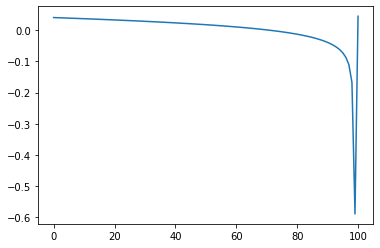

In [63]:
plt.plot(phi[10])